<a href="https://colab.research.google.com/github/thunderhoser/ai2es_xai_course/blob/main/lecture02_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 2: Impurity importance, sequential selection, partial-dependence plots

This notebook was used for the AI2ES (NSF Institute for Research on Trustworthy Artificial Intelligence in Weather, Climate, and Coastal Oceanography) short course on XAI (explainable artificial intelligence) in May-June 2021.

If you use code from this notebook, please cite it as follows.

Lagerquist, Ryan, and David John Gagne II, 2021: "Lecture 2: Impurity importance, sequential selection, partial-dependence plots". AI2ES (NSF Institute for Research on Trustworthy Artificial Intelligence in Weather, Climate, and Coastal Oceanography) short course on XAI (explainable artificial intelligence), https://github.com/thunderhoser/ai2es_xai_course/.

# References

This notebook refers to a few publications, listed below.  Schwartz *et al.* (2015) documents the dataset used.

Friedman, J., 2001: “Greedy function approximation: A gradient boosting machine.” *Annals of Statistics*, **29**, 1189-1232,
https://doi.org/10.1214/aos/1013203451.

McGovern, A., R. Lagerquist, D. Gagne, G. Jergensen, K. Elmore, C. Homeyer, and T. Smith, 2019: “Making the black box more transparent:
Understanding the physical implications of machine learning.” *Bulletin of the American Meteorological Society*, **100 (11)**, 2175-2199,
https://doi.org/10.1175/BAMS-D-18-0195.1.

Schwartz, C., G. Romine, M. Weisman, R. Sobash, K. Fossell, K. Manning, and S. Trier, 2015: "A real-time convection-allowing ensemble prediction system initialized by mesoscale ensemble Kalman filter analyses." *Weather and Forecasting*, **30 (5)**, 1158-1181, https://doi.org/10.1175/WAF-D-15-0013.1.

Webb, A., 2003: “Statistical Pattern Recognition.” John Wiley and Sons, 514 pp.

# <font color='red'>Clone the Git repository (required)</font>

- **Please note**: when a section title is in <font color='red'>red</font>, that means the code cell below is required.
- In other words, if you don't run the code cell below, subsequent code cells might not work.

In [ ]:
import os
import shutil

if os.path.isdir('course_repository'):
    shutil.rmtree('course_repository')

!git clone https://github.com/thunderhoser/ai2es_xai_course course_repository
!cd course_repository; python setup.py install

Cloning into 'course_repository'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 109 (delta 62), reused 73 (delta 30), pack-reused 0
Receiving objects: 100% (109/109), 62.92 MiB | 38.46 MiB/s, done.
Resolving deltas: 100% (62/62), done.
running install
running bdist_egg
running egg_info
creating ai2es_xai_course.egg-info
writing ai2es_xai_course.egg-info/PKG-INFO
writing dependency_links to ai2es_xai_course.egg-info/dependency_links.txt
writing requirements to ai2es_xai_course.egg-info/requires.txt
writing top-level names to ai2es_xai_course.egg-info/top_level.txt
writing manifest file 'ai2es_xai_course.egg-info/SOURCES.txt'
adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
writing manifest file 'ai2es_xai_course.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating b

# <font color='red'>Import packages (required)</font>

The next two cells import all packages used in the notebook.

In [ ]:
import sys

sys.path.append('/content/data/')
sys.path.append('/content/course_repository/')
sys.path.append('/content/course_repository/ai2es_xai_course/')
sys.path.append('/content/course_repository/ai2es_xai_course/utils/')

In [ ]:
%matplotlib inline
import copy
import os.path
import warnings
import numpy
import keras
from matplotlib import pyplot
from ai2es_xai_course.utils import utils
from ai2es_xai_course.utils import sequential_selection

warnings.filterwarnings('ignore')

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

DATA_DIRECTORY_NAME = '/content/data/track_data_ncar_ams_3km_csv_small'

# <font color='red'>Prevent auto-scrolling (required)</font>

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# <font color='red'>Download input data (required)</font>

The next cell downloads all input data used in this notebook.

In [ ]:
!python /content/course_repository/download_tabular_data.py

Unzipping file: "data/track_data_ncar_ams_3km_csv_small.tar.gz"...


# <font color='red'>Read input data (required)</font>

The next cell reads all input data for this notebook into memory.

In [ ]:
training_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20100101',
    last_date_string='20141231'
)
validation_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20150101',
    last_date_string='20151231'
)
testing_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20160101',
    last_date_string='20171231'
)

(training_metadata_table, training_predictor_table_denorm,
 training_target_table
) = utils.read_many_tabular_files(training_file_names)
print(MINOR_SEPARATOR_STRING)

(validation_metadata_table, validation_predictor_table_denorm,
 validation_target_table
) = utils.read_many_tabular_files(validation_file_names)
print(MINOR_SEPARATOR_STRING)

(testing_metadata_table, testing_predictor_table_denorm,
 testing_target_table
) = utils.read_many_tabular_files(testing_file_names)
print(MINOR_SEPARATOR_STRING)

print('Variables in metadata are as follows:\n{0:s}'.format(
    str(list(training_metadata_table))
))

print('\nPredictor variables are as follows:\n{0:s}'.format(
    str(list(training_predictor_table_denorm))
))

print('\nTarget variable is as follows:\n{0:s}'.format(
    str(list(training_target_table))
))

first_predictor_name = list(training_predictor_table_denorm)[0]
these_predictor_values = (
    training_predictor_table_denorm[first_predictor_name].values[:10]
)

message_string = (
    '\nValues of predictor variable "{0:s}" for the first training '
    'examples:\n{1:s}'
).format(first_predictor_name, str(these_predictor_values))
print(message_string)

target_name = list(training_target_table)[0]
these_target_values = training_target_table[target_name].values[:10]

message_string = (
    '\nValues of target variable for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_N

# <font color='red'>Normalization (required)</font>

The next cell does the following:

 - Finds normalization parameters (mean and standard deviation) for each predictor, based only on the training data.
 - Normalizes the training, validation, and testing data.
 - Denormalizes the training data and ensures that denormalized values = original values (sanity check).

In [ ]:
predictor_names = list(training_predictor_table_denorm)
these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    'Original values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table, normalization_dict = utils.normalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table_denorm)
)

these_predictor_values = (
    training_predictor_table[predictor_names[0]].values[:10]
)

message_string = (
    '\nNormalized values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table_denorm = utils.denormalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table),
    normalization_dict=normalization_dict
)

these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    '\n*De*normalized values (should equal original values) of "{0:s}" for '
    'the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

validation_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(validation_predictor_table_denorm),
    normalization_dict=normalization_dict
)

testing_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(testing_predictor_table_denorm),
    normalization_dict=normalization_dict
)

Original values of "composite_refl_mean_dbz" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]

Normalized values of "composite_refl_mean_dbz" for the first training examples:
[-1.03619508  0.06182963 -0.32830456 -0.63672124 -0.55287024 -0.62955524
 -0.27959332 -0.79199632 -0.36799241  0.11659495]

*De*normalized values (should equal original values) of "composite_refl_mean_dbz" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]


# <font color='red'>Binarize target variable (required)</font>

- The next cell binarizes the target variable (max future vorticity in s$^{-1}$).
- **Binarization turns each value into a 0 (no) or 1 (yes), based on whether or not future vorticity reaches a threshold.**
- This is necessary because the AI models used in this notebook do classification, not regression.
- However, similar AI models (linear instead of logistic regression; a random forest that estimates real values instead of class probabilities) can be used for regression.

In [ ]:
binarization_threshold = utils.get_binarization_threshold(
    tabular_file_names=training_file_names, percentile_level=90.
)
print(MINOR_SEPARATOR_STRING)

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[1030:1050]
)

message_string = (
    'Real-numbered target values for a few training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

training_target_values = utils.binarize_target_values(
    target_values=training_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
training_target_table = training_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: training_target_values}
)

print('\nBinarization threshold = {0:.3e} s^-1'.format(
    binarization_threshold
))

these_target_values = (
    training_target_table[utils.BINARIZED_TARGET_NAME].values[1030:1050]
)

message_string = (
    '\nBinarized target values for the same training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

validation_target_values = utils.binarize_target_values(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
validation_target_table = validation_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: validation_target_values}
)

testing_target_values = utils.binarize_target_values(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
testing_target_table = testing_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: testing_target_values}
)

Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_N

# Random forest

The next two code cells train and evaluate a random forest.  Two explanation methods (impurity importance and partial-dependence plots) will be run on this random forest.

## <font color='red'>Training (required)</font>

The next cell trains a random forest with the following hyperparameters:

 - 100 trees
 - 6 predictors attempted at each leaf node
 - Minimum of 500 examples at a branch node
 - Minimum of 200 examples at a leaf node

In [ ]:
num_predictors = len(list(training_predictor_table))
max_predictors_per_split = int(numpy.round(
    numpy.sqrt(num_predictors)
))

random_forest_model_object = utils.setup_classification_forest(
    max_predictors_per_split=max_predictors_per_split,
    num_trees=100, min_examples_at_split=500, min_examples_at_leaf=200
)

_ = utils.train_classification_forest(
    model_object=random_forest_model_object,
    training_predictor_table=training_predictor_table,
    training_target_table=training_target_table
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   33.1s finished


## Evaluation

 - The next cell evaluates the model we just trained.
 - Performance on the validation data is excellent (AUC $>$ 0.9), which means that it is worth explaining the model.
 - If performance were poor, explainable AI would probably not be worthwhile.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


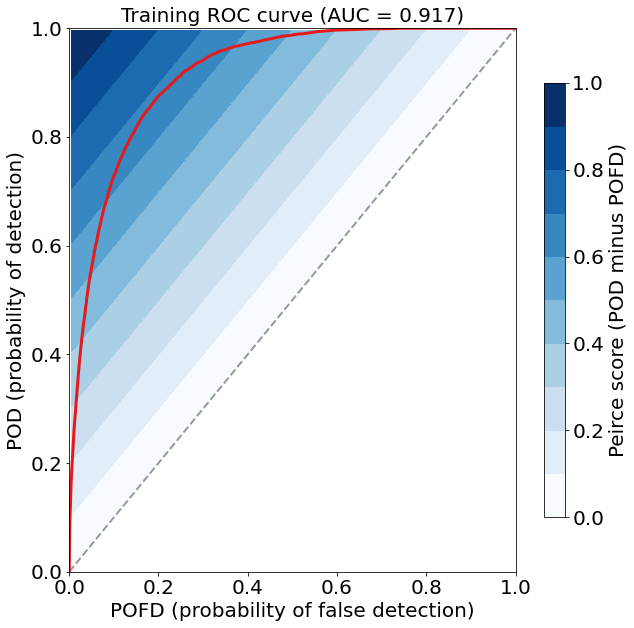

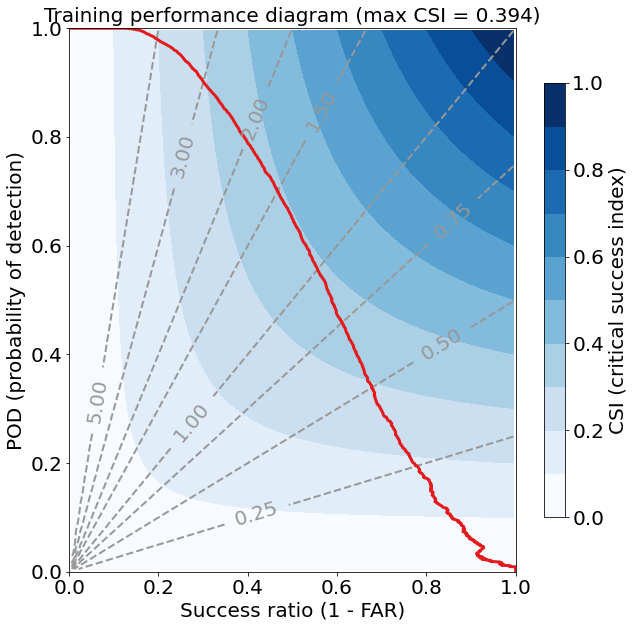

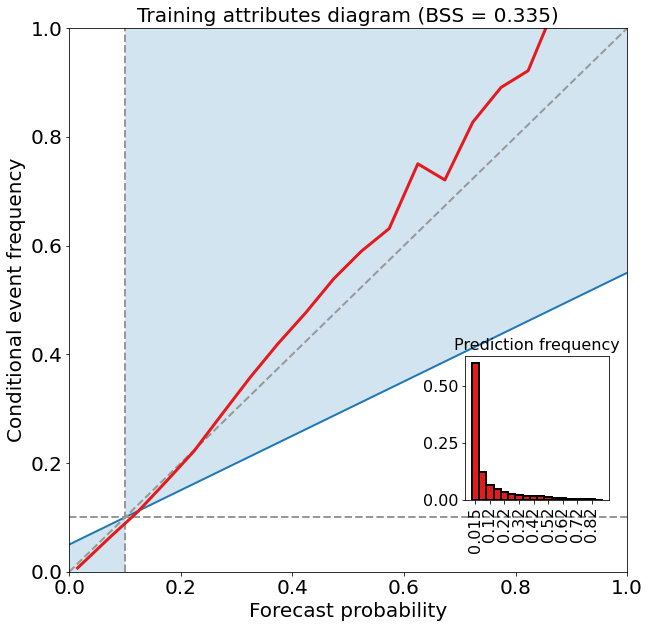

Training max Peirce score (POD - POFD) = 0.675
Training AUC (area under ROC curve) = 0.917
Training max CSI (critical success index) = 0.394
Training Brier score = 0.060
Training Brier skill score (improvement over climatology) = 0.335


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


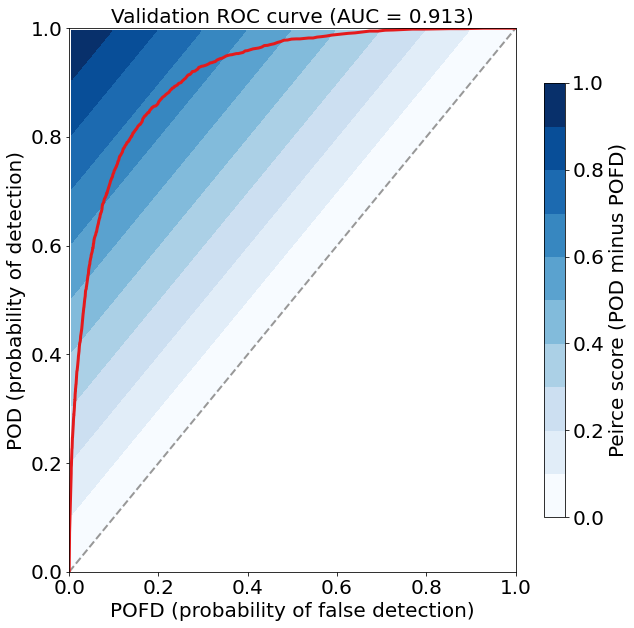

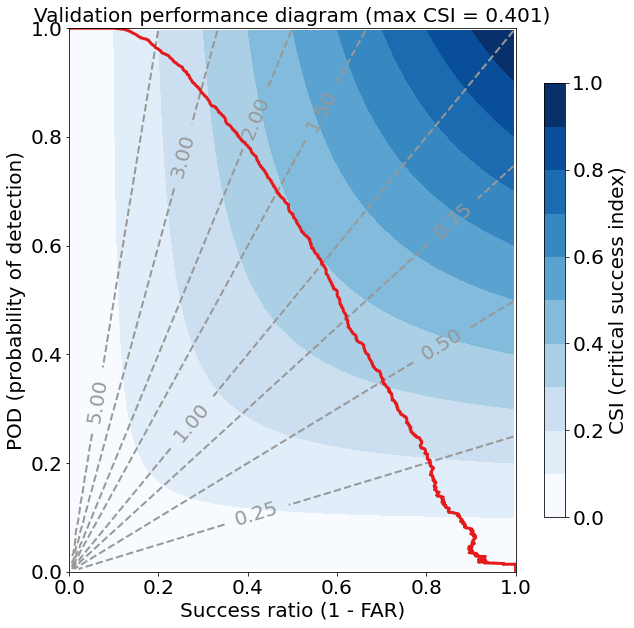

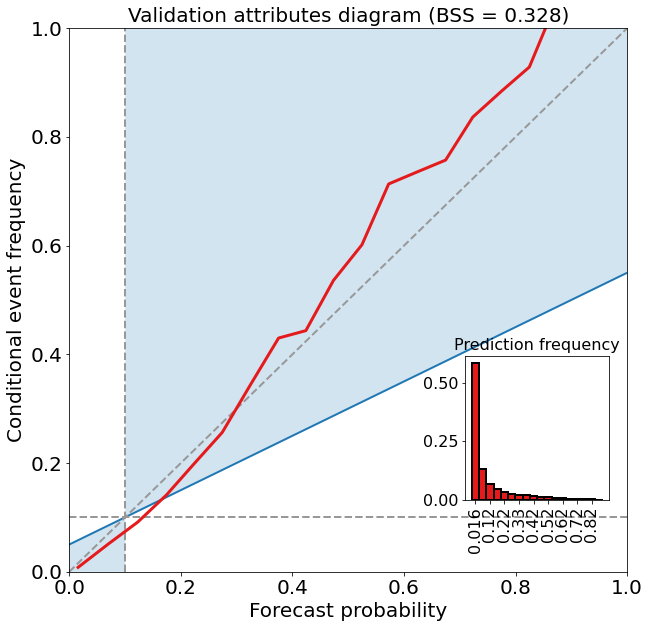

Validation max Peirce score (POD - POFD) = 0.670
Validation AUC (area under ROC curve) = 0.913
Validation max CSI (critical success index) = 0.401
Validation Brier score = 0.061
Validation Brier skill score (improvement over climatology) = 0.328


In [ ]:
training_probabilities = random_forest_model_object.predict_proba(
    training_predictor_table.to_numpy()
)[:, 1]
training_event_frequency = numpy.mean(
    training_target_table[utils.BINARIZED_TARGET_NAME].values
)

_ = utils.eval_binary_classifn(
    observed_labels=
    training_target_table[utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=training_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='training'
)

validation_probabilities = random_forest_model_object.predict_proba(
    validation_predictor_table.to_numpy()
)[:, 1]

_ = utils.eval_binary_classifn(
    observed_labels=
    validation_target_table[utils.BINARIZED_TARGET_NAME].values,
    forecast_probabilities=validation_probabilities,
    training_event_frequency=training_event_frequency,
    dataset_name='validation'
)

# Impurity importance: Theory

 - Popular method for ranking predictor importance, because it is automatically computed during training in scikit-learn.
 - **However, impurity importance can be used only for decision trees and forests.**
 - **The importance of predictor $x_j$ is defined as:**
<br><br>
$I(x_j) = \frac{1}{T} \sum\limits_{k = 1}^{T} \sum\limits_{s \in S_{x_j}^{(k)}} f_s \Delta \epsilon_s$
<br><br>
 - $T$ = number of trees
 - $S_{x_j}^{(k)}$ = set of split nodes in $k^{\textrm{th}}$ tree that involve $x_j$
 - $f_s$ = fraction of training examples that reach node $s$
 - $\Delta \epsilon_s$ = decrease in impurity score (Gini or entropy) achieved by split node $s$
<br><br>
**Thus, predictor $x_j$ is considered important if:**
 - It shows up earlier in the tree (higher $f_s$)
 - It achieves a greater decrease in impurity (higher $\Delta \epsilon_s$)
<br><br>
**Advantages of impurity importance:**
 - Explanation is succinct (list of important predictors)
 - Computationally efficient
 - Easy to implement (automatically computed during training)
<br><br>
**Disadvantages:**
 - Works only for decision trees and forests
 - Does not explain how/why a predictor is important
 - Computed only for training data
   - However, you could implement your own version for validation or testing data
 - Predictors that show up earlier in tree, may not be truly more important

# Impurity importance: Code

The next cell plots impurity importance, based on the training data, for the random forest.

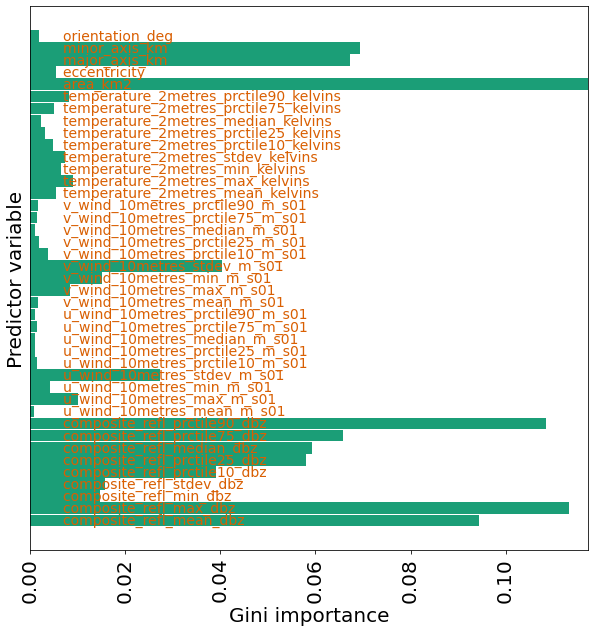

In [ ]:
utils.plot_gini_importances(
    gini_importances=random_forest_model_object.feature_importances_,
    predictor_names=predictor_names
)

# Sequential forward selection (SFS): Theory

 - SFS is another method for ranking predictor importance.
 - Unlike the other methods described so far (Lectures 1 and 2), SFS:
   - Explicitly adds predictors to the AI model
   - Involves retraining the AI model, instead of using a pre-trained model
<br><br>
 - **The procedure is below**, letting $\mathcal{U}$ = set of unselected predictors, $\mathcal{S}$ = set of selected predictors, $\epsilon$ = current model error.
<br><br>
 1. Initialize: $\mathcal{U}$ = {all predictors}, $\mathcal{S}$ = empty set, $\epsilon = \infty$
 2. For each remaining predictor $u$ in $\mathcal{U}$:
    - Train new model with predictors $\mathcal{S} + \lbrace u \rbrace$.
    - Compute error of new model on validation set.
 3. Find minimum validation error for new models (with predictors $\mathcal{S}$ plus one extra).
 4. Let minimum validation error be $\epsilon_{new}^*$ and corresponding predictor be $u^*$.
 5. If $\epsilon_{new}^* \ge \epsilon$, stop!
 6. Otherwise, set $\epsilon \leftarrow \epsilon_{new}^*$, add $u^*$ to $\mathcal{S}$, remove $u^*$ from $\mathcal{U}$, and return to step 2.
<br><br>
 - **More colloquially, we can think of SFS as 99 Bottles of Beer on the Wall, where each beer bottle is a predictor.**
 - At the $k^{\textrm{th}}$ step, $k - 1$ predictors (bottles) have been selected (taken off the wall).
 - The goal is to find the one remaining predictor that, when added to those already selected, yields the best $k$-predictor model.
 - In the procedure on the last slide, stopping criterion is "if validation error does not decrease when adding the new predictor".
 - However, we can make the stopping criterion "if validation error does not decrease substantially when adding the new predictor," to encourage a smaller model.
<br><br>
**Advantages of SFS:**
 - Can be applied to any AI model (model-type-agnostic)
 - Often leads to small model (few predictors – more computationally efficient at inference time)
 - Explanation is succinct (list of important predictors)
<br><br>
**Disadvantages**:
 - Method is computationally inefficient
   - Model is retrained up to $\frac{1}{2}M(M - 1)$ times, where $M$ = number of predictors
 - Does not explain how/why predictors are important
 - Greedy algorithm (adds one predictor at a time and cannot remove predictors)
 - Considers only one predictor at a time (no interactions among predictors)

# Sequential forward selection (SFS): Code

## Run SFS

 - The next cell runs SFS, using logistic regression with an L$_1$ weight of $10^{-6.5}$ and L$_2$ weight of $10^{-4}$.
 - Note that SFS involves training a new model for every set of predictor variables, so we are not reusing the same logistic-regression model.
 - We are reusing the same model type and hyperparameters, but we are retraining at every step.
<br><br>
 - **Our cost function is negative area under the ROC curve (AUC), computed on the validation data.**
 - **Note that SFS uses only the training data (to train the model) and validation data (to determine the best predictor set), no testing data.**
 - This is because the predictor set is a hyperparameter and hyperparameter-tuning should be based on the validation data, never the testing data.

In [ ]:
model_object = utils.setup_logistic_regression(
    lambda1=10 ** -6.5, lambda2=10 ** -4
)

selected_predictor_names, validation_auc_values = (
    sequential_selection.run_forward_selection(
        training_predictor_table=training_predictor_table,
        validation_predictor_table=validation_predictor_table,
        training_target_table=training_target_table,
        validation_target_table=validation_target_table,
        sklearn_model_object=model_object
    )
)

Step 1 of forward selection: 0 predictors selected, 41 remaining...
Max validation AUC (0.8736) given by adding composite_refl_max_dbz (previous max AUC = -inf)
Step 2 of forward selection: 1 predictors selected, 40 remaining...
Max validation AUC (0.8914) given by adding area_km2 (previous max AUC = 0.8736)
Step 3 of forward selection: 2 predictors selected, 39 remaining...
Max validation AUC (0.8965) given by adding u_wind_10metres_stdev_m_s01 (previous max AUC = 0.8914)
Step 4 of forward selection: 3 predictors selected, 38 remaining...
Max validation AUC (0.8996) given by adding composite_refl_mean_dbz (previous max AUC = 0.8965)
Step 5 of forward selection: 4 predictors selected, 37 remaining...
Max validation AUC (0.9003) given by adding major_axis_km (previous max AUC = 0.8996)


## Plot results

The next cell plots results.  The first predictor selected is at the top, and the last predictor selected is at the bottom.
<br><br>
The four predictors included in the model (your results may differ due to randomness) were also identified as important by the $J$-measure, permutation test, and impurity importance:
 - Maximum reflectivity inside storm
 - Storm area
 - Standard deviation of $u$-wind inside storm
 - Mean reflectivity inside storm

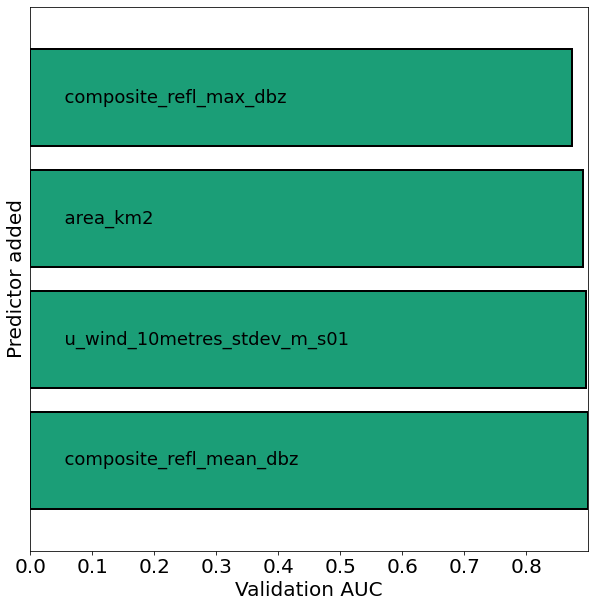

In [ ]:
sequential_selection.plot_results(
    predictor_names=selected_predictor_names,
    validation_auc_values=validation_auc_values, is_forward_test=True
)

# Sequential backward selection (SBS): Theory

 - SBS is SFS in reverse.
 - At each step, SBS explicitly removes a predictor from the AI model.
 - SBS also involves retraining the AI model, rather than using a pre-trained model.
<br><br>
 - **The procedure is below**, letting $\mathcal{S}$ = set of selected predictors and $\epsilon$ = current model error.
<br><br>
 1. Initialize: $\mathcal{S}$ = {all predictors}, $\epsilon = \infty$
 2. For each remaining predictor $s$ in $\mathcal{S}$:
    - Train new model with predictors $\mathcal{S} - \lbrace s \rbrace$.
    - Compute error of new model on validation set.
 3. Find minimum validation error for new models (with all but one predictor in $\mathcal{S}$).
 4. Let minimum validation error be $\epsilon_{new}^*$ and corresponding predictor be $s^*$.
 5. If $\epsilon_{new}^* \ge \epsilon$, stop!
 6. Otherwise, set $\epsilon \leftarrow \epsilon_{new}^*$, remove $s^*$ from $\mathcal{S}$, and return to step 2.
<br><br>
 - **We can think of SBS as 99 Bottles of Beer on the Wall (where each beer bottle is a predictor) in reverse.**
 - At the $k^{\textrm{th}}$ step, $k - 1$ predictors (bottles) have been removed from the model (put back on the wall).
 - The goal is to find the one predictor that, when removed from the model, yields the best $k$-predictor model.
 - In the procedure on the last slide, stopping criterion is "if validation error does not decrease when removing the predictor".
 - However, we can make the stopping criterion "if validation error does not increase substantially when adding the new predictor," to encourage a smaller model.
<br><br>
**Advantages of SBS:**
 - Same as SFS
<br><br>
**Disadvantages**:
 - Method is computationally inefficient
   - If stopping criterion is reached before looping thru all predictors, SBS is more inefficient than SFS
   - This is because first steps of SBS involve large models, while first steps of SFS involve small models
 - Does not explain how/why predictors are important
 - Greedy algorithm (removes one predictor at a time and cannot add predictors)
 - Considers only one predictor at a time

# Sequential backward selection (SBS): Code

## Run SBS

The next cell runs SBS, using logistic regression with an L$_1$ weight of $10^{-6.5}$ and L$_2$ weight of $10^{-4}$.  We used the same hyperparameters above for SFS.

In [ ]:
model_object = utils.setup_logistic_regression(
    lambda1=10 ** -6.5, lambda2=10 ** -4
)

removed_predictor_names, validation_auc_values = (
    sequential_selection.run_backward_selection(
        training_predictor_table=training_predictor_table,
        validation_predictor_table=validation_predictor_table,
        training_target_table=training_target_table,
        validation_target_table=validation_target_table,
        sklearn_model_object=model_object
    )
)

Step 1 of backward selection: 0 predictors removed, 41 remaining...
Max validation AUC (0.9042) given by removing v_wind_10metres_prctile90_m_s01 (previous max AUC = -inf)
Step 2 of backward selection: 1 predictors removed, 40 remaining...
Max validation AUC (0.9109) given by removing composite_refl_prctile90_dbz (previous max AUC = 0.9042)
Step 3 of backward selection: 2 predictors removed, 39 remaining...
Max validation AUC (0.9111) given by removing composite_refl_prctile75_dbz (previous max AUC = 0.9109)
Step 4 of backward selection: 3 predictors removed, 38 remaining...
Max validation AUC (0.9112) given by removing composite_refl_max_dbz (previous max AUC = 0.9111)
Step 5 of backward selection: 4 predictors removed, 37 remaining...
Max validation AUC (0.9113) given by removing temperature_2metres_median_kelvins (previous max AUC = 0.9112)
Step 6 of backward selection: 5 predictors removed, 36 remaining...
Max validation AUC (0.9116) given by removing v_wind_10metres_min_m_s01 (pre

## Plot results

 - The next cell plots results.  The first predictor removed is at the top, and the last predictor removed is at the bottom.
 - This cell also prints the list of predictors that were left in the model (*i.e.*, not removed from the model -- considered important).
<br><br>
 - The 12 predictors left in the model (your results may differ due to randomness) do not include all 4 of the predictors chosen by SFS.
 - In fact, the 12 predictors left in the model include only one predictor chosen by SFS (storm area).
 - However, for the other three predictors chosen by SFS, there is a similar predictor left in the model by SBS.
   - SFS: mean and maximum reflectivity; SBS: 25$^\textrm{th}$-percentile and standard deviation of reflectivity
   - SFS: standard deviation of $u$-wind; SBS: min, max, 10$^\textrm{th}$-percentile, and 90$^\textrm{th}$-percentile $u$-wind

Predictors still in the model:
v_wind_10metres_prctile10_m_s01
eccentricity
v_wind_10metres_stdev_m_s01
u_wind_10metres_prctile10_m_s01
major_axis_km
u_wind_10metres_prctile90_m_s01
composite_refl_prctile25_dbz
area_km2
u_wind_10metres_min_m_s01
u_wind_10metres_max_m_s01
composite_refl_stdev_dbz
v_wind_10metres_max_m_s01





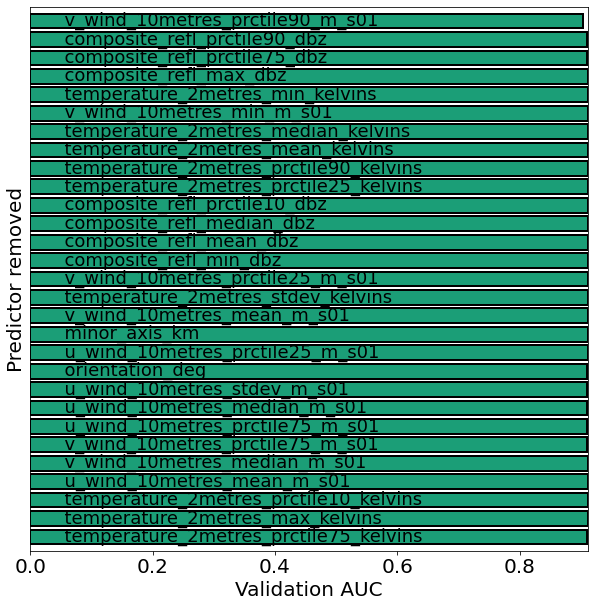

In [ ]:
selected_predictor_names = list(
    set(list(training_predictor_table)) -
    set(removed_predictor_names)
)

print('Predictors still in the model:')
for this_name in selected_predictor_names:
    print(this_name)

print('\n\n')

_ = sequential_selection.plot_results(
    predictor_names=removed_predictor_names,
    validation_auc_values=validation_auc_values, is_forward_test=False
)

# Partial-dependence plots (PDP): Theory

 - **None of the methods discussed so far explain how/why a predictor is important.**
 - **PDPs (Friedman 2001) address this problem** by showing the average prediction for many values of the
predictor.
 - **The procedure is below**, letting the predictor of interest be $x_j$.
<br><br>
 1. Pick a large number of trial values for $x_j$.
    - This notebook picks 101 values by default: the 0$^{\textrm{th}}$, 1$^{\textrm{st}}$, ..., 99$^{\textrm{th}}$, and 100$^{\textrm{th}}$ percentiles.
 2. For each trial value $x_j^{(t)}$:
    - Copy the clean testing data and set $x_j = x_j^{(t)}$ for every example.  This is termed a "causal intervention".
    - Run the model on the perturbed testing data and record the average prediction.
 3. Plot average model prediction vs. trial value.
<br><br>
**Advantages of PDP**:
 - Explanation is succinct (one graph per predictor)
 - Computationally efficient (if model is efficient and dataset is not huge)
 - Has a causal interpretation ("what happens when a *deus ex machina* comes along and changes the value of $x_j$?")
<br><br>
**Disadvantages**:
 - Does not give overall importance of each predictor
   - However, PDP can be used in tandem with another explanation method
   - In the notebooks we use other methods ($J$-measure, permutation, impurity, SFS, SBS) to find important predictors, then run PDP for important predictors
 - Computationally inefficient (if model is inefficient or dataset is huge)
 - Considers only one predictor at a time (no interactions among predictors)
   - This problem is addressed by accumulated local effects (ALE) plots
 - Averaging over all testing examples may hide heterogeneous effects
   - This problem is addressed by individual conditional expectation (ICE) plots
<br><br>
 - Section 5.1 of *Interpretable Machine Learning* by Molnar (https://christophm.github.io/interpretable-mlbook/pdp.html) has a great discussion of the (dis)advantages of PDP.
 - Sections 5.2 and 5.3 discuss ALE and ICE plots, respectively.
 - We may or may not discuss ALE and ICE plots later in this course.

# Partial-dependence plots (PDP): Code

The next cells create PDPs for various predictors.

## PDP for maximum reflectivity

 - The next cell creates the PDP for maximum composite (column-max) reflectivity inside the storm.
 - Strong-rotation probability increases monotonically with maximum reflectivity, most dramatically from approx 60-67 dBZ.

Applying model to data with composite_refl_max_dbz = 40...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 42...
Applying model to data with composite_refl_max_dbz = 42...
Applying model to data with composite_refl_max_dbz = 43...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 43...
Applying model to data with composite_refl_max_dbz = 43...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_max_dbz = 44...
Applying model to data with composite_refl_max_dbz = 44...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 44...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 44...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 45...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 45...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_max_dbz = 45...
Applying model to data with composite_refl_max_dbz = 45...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 45...
Applying model to data with composite_refl_max_dbz = 46...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 46...
Applying model to data with composite_refl_max_dbz = 46...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 46...
Applying model to data with composite_refl_max_dbz = 46...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_max_dbz = 46...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 47...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_max_dbz = 47...
Applying model to data with composite_refl_max_dbz = 47...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 47...
Applying model to data with composite_refl_max_dbz = 47...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_max_dbz = 47...
Applying model to data with composite_refl_max_dbz = 48...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 48...
Applying model to data with composite_refl_max_dbz = 48...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 48...
Applying model to data with composite_refl_max_dbz = 48...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 48...
Applying model to data with composite_refl_max_dbz = 49...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 49...
Applying model to data with composite_refl_max_dbz = 49...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 49...
Applying model to data with composite_refl_max_dbz = 49...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 49...
Applying model to data with composite_refl_max_dbz = 50...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 50...
Applying model to data with composite_refl_max_dbz = 50...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 50...
Applying model to data with composite_refl_max_dbz = 50...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 51...
Applying model to data with composite_refl_max_dbz = 51...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 51...
Applying model to data with composite_refl_max_dbz = 51...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 52...
Applying model to data with composite_refl_max_dbz = 52...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 52...
Applying model to data with composite_refl_max_dbz = 53...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 53...
Applying model to data with composite_refl_max_dbz = 53...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 54...
Applying model to data with composite_refl_max_dbz = 54...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 54...
Applying model to data with composite_refl_max_dbz = 55...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 55...
Applying model to data with composite_refl_max_dbz = 55...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 55...
Applying model to data with composite_refl_max_dbz = 56...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 56...
Applying model to data with composite_refl_max_dbz = 56...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 57...
Applying model to data with composite_refl_max_dbz = 57...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 57...
Applying model to data with composite_refl_max_dbz = 58...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 58...
Applying model to data with composite_refl_max_dbz = 58...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 59...
Applying model to data with composite_refl_max_dbz = 59...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 59...
Applying model to data with composite_refl_max_dbz = 60...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 60...
Applying model to data with composite_refl_max_dbz = 60...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 61...
Applying model to data with composite_refl_max_dbz = 61...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 61...
Applying model to data with composite_refl_max_dbz = 62...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 62...
Applying model to data with composite_refl_max_dbz = 62...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 63...
Applying model to data with composite_refl_max_dbz = 63...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 63...
Applying model to data with composite_refl_max_dbz = 64...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 64...
Applying model to data with composite_refl_max_dbz = 65...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 65...
Applying model to data with composite_refl_max_dbz = 65...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 66...
Applying model to data with composite_refl_max_dbz = 66...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 67...
Applying model to data with composite_refl_max_dbz = 67...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 68...
Applying model to data with composite_refl_max_dbz = 68...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 69...
Applying model to data with composite_refl_max_dbz = 70...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_max_dbz = 72...
Applying model to data with composite_refl_max_dbz = 74...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_max_dbz = 81...


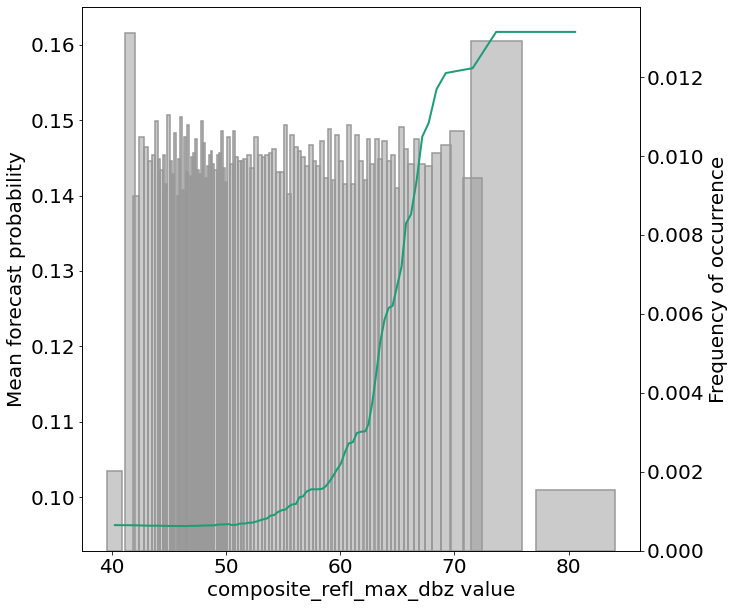

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    model_object=random_forest_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='composite_refl_max_dbz', num_trial_values=101
)

utils.plot_pdp(
    trial_predictor_name='composite_refl_max_dbz',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)

## PDP for mean reflectivity

 - The next cell creates the PDP for mean composite (column-max) reflectivity inside the storm.
 - Strong-rotation probability increases monotonically with mean reflectivity, most dramatically from approx 45-55 dBZ.

Applying model to data with composite_refl_mean_dbz = 40...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 41...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 41...
Applying model to data with composite_refl_mean_dbz = 41...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 42...
Applying model to data with composite_refl_mean_dbz = 42...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 42...
Applying model to data with composite_refl_mean_dbz = 42...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 42...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 42...
Applying model to data with composite_refl_mean_dbz = 42...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 42...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 43...
Applying model to data with composite_refl_mean_dbz = 43...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 43...
Applying model to data with composite_refl_mean_dbz = 43...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 43...
Applying model to data with composite_refl_mean_dbz = 43...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 43...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 43...
Applying model to data with composite_refl_mean_dbz = 43...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 43...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 43...
Applying model to data with composite_refl_mean_dbz = 43...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with composite_refl_mean_dbz = 44...
Applying model to data with composite_refl_mean_dbz = 44...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 44...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 44...
Applying model to data with composite_refl_mean_dbz = 44...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 44...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 44...
Applying model to data with composite_refl_mean_dbz = 44...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 44...
Applying model to data with composite_refl_mean_dbz = 44...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with composite_refl_mean_dbz = 44...
Applying model to data with composite_refl_mean_dbz = 45...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 45...
Applying model to data with composite_refl_mean_dbz = 45...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 45...
Applying model to data with composite_refl_mean_dbz = 45...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 45...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 45...
Applying model to data with composite_refl_mean_dbz = 45...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 45...
Applying model to data with composite_refl_mean_dbz = 45...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 46...
Applying model to data with composite_refl_mean_dbz = 46...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 46...
Applying model to data with composite_refl_mean_dbz = 46...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with composite_refl_mean_dbz = 46...
Applying model to data with composite_refl_mean_dbz = 46...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 46...
Applying model to data with composite_refl_mean_dbz = 46...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with composite_refl_mean_dbz = 46...
Applying model to data with composite_refl_mean_dbz = 47...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 47...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 47...
Applying model to data with composite_refl_mean_dbz = 47...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with composite_refl_mean_dbz = 47...
Applying model to data with composite_refl_mean_dbz = 47...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 47...
Applying model to data with composite_refl_mean_dbz = 47...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with composite_refl_mean_dbz = 48...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 48...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 48...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 48...
Applying model to data with composite_refl_mean_dbz = 48...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 48...
Applying model to data with composite_refl_mean_dbz = 48...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with composite_refl_mean_dbz = 48...
Applying model to data with composite_refl_mean_dbz = 49...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 49...
Applying model to data with composite_refl_mean_dbz = 49...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 49...
Applying model to data with composite_refl_mean_dbz = 49...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 49...
Applying model to data with composite_refl_mean_dbz = 49...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 50...
Applying model to data with composite_refl_mean_dbz = 50...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 50...
Applying model to data with composite_refl_mean_dbz = 50...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 50...
Applying model to data with composite_refl_mean_dbz = 51...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 51...
Applying model to data with composite_refl_mean_dbz = 51...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 51...
Applying model to data with composite_refl_mean_dbz = 52...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 52...
Applying model to data with composite_refl_mean_dbz = 52...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 52...
Applying model to data with composite_refl_mean_dbz = 53...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 53...
Applying model to data with composite_refl_mean_dbz = 54...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 54...
Applying model to data with composite_refl_mean_dbz = 55...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 56...
Applying model to data with composite_refl_mean_dbz = 57...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 58...
Applying model to data with composite_refl_mean_dbz = 60...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with composite_refl_mean_dbz = 70...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


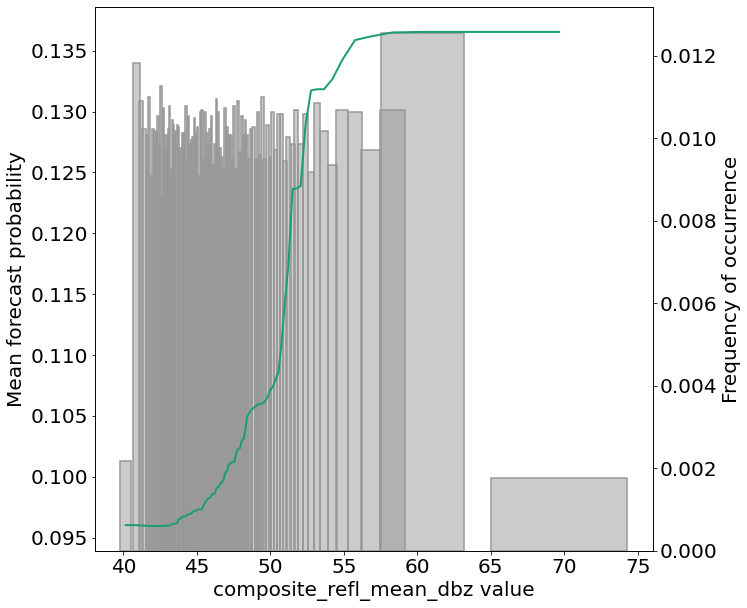

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    model_object=random_forest_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='composite_refl_mean_dbz', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='composite_refl_mean_dbz',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)

## PDP for storm area

 - The next cell creates the PDP for storm area (areal extent in km$^2$).
 - Strong-rotation probability increases monotonically with storm area, most dramatically from approx 200-800 km$^{2}$.

Applying model to data with area_km2 = 36...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 36...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with area_km2 = 36...
Applying model to data with area_km2 = 36...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 36...
Applying model to data with area_km2 = 45...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with area_km2 = 45...
Applying model to data with area_km2 = 45...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 54...
Applying model to data with area_km2 = 54...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 54...
Applying model to data with area_km2 = 63...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 63...
Applying model to data with area_km2 = 63...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with area_km2 = 72...
Applying model to data with area_km2 = 72...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 72...
Applying model to data with area_km2 = 81...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 81...
Applying model to data with area_km2 = 81...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with area_km2 = 90...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with area_km2 = 90...
Applying model to data with area_km2 = 99...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 99...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 99...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 1.1e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 1.1e+02...
Applying model to data with area_km2 = 1.2e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 1.2e+02...
Applying model to data with area_km2 = 1.3e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 1.3e+02...
Applying model to data with area_km2 = 1.4e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 1.4e+02...
Applying model to data with area_km2 = 1.4e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 1.4e+02...
Applying model to data with area_km2 = 1.5e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 1.5e+02...
Applying model to data with area_km2 = 1.6e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 1.6e+02...
Applying model to data with area_km2 = 1.7e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 1.8e+02...
Applying model to data with area_km2 = 1.8e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with area_km2 = 1.9e+02...
Applying model to data with area_km2 = 1.9e+02...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 2e+02...
Applying model to data with area_km2 = 2.1e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 2.2e+02...
Applying model to data with area_km2 = 2.2e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 2.2e+02...
Applying model to data with area_km2 = 2.3e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 2.4e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 2.5e+02...
Applying model to data with area_km2 = 2.6e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 2.7e+02...
Applying model to data with area_km2 = 2.8e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 2.9e+02...
Applying model to data with area_km2 = 3e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 3.2e+02...
Applying model to data with area_km2 = 3.2e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 3.3e+02...
Applying model to data with area_km2 = 3.5e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 3.6e+02...
Applying model to data with area_km2 = 3.8e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 3.9e+02...
Applying model to data with area_km2 = 4.0e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 4.2e+02...
Applying model to data with area_km2 = 4.3e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 4.5e+02...
Applying model to data with area_km2 = 4.7e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 4.9e+02...
Applying model to data with area_km2 = 5e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 5.2e+02...
Applying model to data with area_km2 = 5.5e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 5.8e+02...
Applying model to data with area_km2 = 5.9e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with area_km2 = 6.2e+02...
Applying model to data with area_km2 = 6.5e+02...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 6.8e+02...
Applying model to data with area_km2 = 7.1e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 7.5e+02...
Applying model to data with area_km2 = 7.8e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 8.2e+02...
Applying model to data with area_km2 = 8.5e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 8.7e+02...
Applying model to data with area_km2 = 8.9e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 9e+02...
Applying model to data with area_km2 = 9e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 9.1e+02...
Applying model to data with area_km2 = 9.1e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 9.2e+02...
Applying model to data with area_km2 = 9.2e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 9.3e+02...
Applying model to data with area_km2 = 9.4e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 9.4e+02...
Applying model to data with area_km2 = 9.6e+02...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 9.9e+02...
Applying model to data with area_km2 = 1e+03...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 1.1e+03...
Applying model to data with area_km2 = 1.3e+03...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with area_km2 = 2.7e+03...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


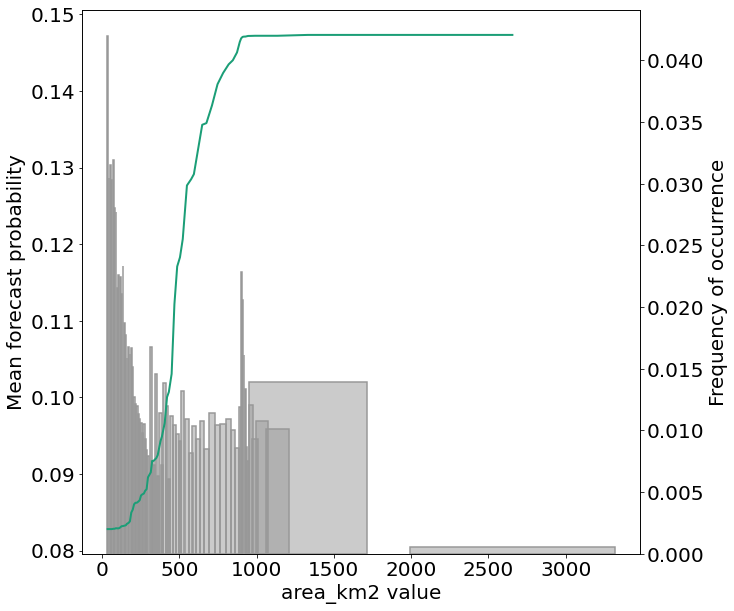

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    model_object=random_forest_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='area_km2', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='area_km2',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)

## PDP for standard deviation of $u$-wind

 - The next cell creates the PDP for the standard deviation of 10-metre $u$-wind (east-west component) inside the storm.
 - Strong-rotation probability increases monotonically with standard deviation of $u$-wind, most dramatically from approx 1-3.5 m s$^{-1}$.

Applying model to data with u_wind_10metres_stdev_m_s01 = 0.0037...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.13...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.17...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.21...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.24...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.27...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.3...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.33...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.36...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.39...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.41...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.44...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.46...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.49...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.51...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.53...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.56...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.58...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.6...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.63...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.65...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.68...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.7...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.73...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.75...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.77...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.8...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.83...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.85...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.88...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.9...
Applying model to data with u_wind_10metres_stdev_m_s01 = 0.92...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.95...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 0.97...
Applying model to data with u_wind_10metres_stdev_m_s01 = 1...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1...
Applying model to data with u_wind_10metres_stdev_m_s01 = 1.1...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.1...
Applying model to data with u_wind_10metres_stdev_m_s01 = 1.1...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.1...
Applying model to data with u_wind_10metres_stdev_m_s01 = 1.2...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.2...
Applying model to data with u_wind_10metres_stdev_m_s01 = 1.2...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.2...
Applying model to data with u_wind_10metres_stdev_m_s01 = 1.3...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.3...
Applying model to data with u_wind_10metres_stdev_m_s01 = 1.3...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.4...
Applying model to data with u_wind_10metres_stdev_m_s01 = 1.4...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.4...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.5...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.5...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.5...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.6...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.6...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.6...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.7...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.7...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.7...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.8...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.8...
Applying model to data with u_wind_10metres_stdev_m_s01 = 1.8...

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished



Applying model to data with u_wind_10metres_stdev_m_s01 = 1.9...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with u_wind_10metres_stdev_m_s01 = 1.9...
Applying model to data with u_wind_10metres_stdev_m_s01 = 2...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with u_wind_10metres_stdev_m_s01 = 2...
Applying model to data with u_wind_10metres_stdev_m_s01 = 2...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 2.1...
Applying model to data with u_wind_10metres_stdev_m_s01 = 2.1...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with u_wind_10metres_stdev_m_s01 = 2.2...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 2.2...
Applying model to data with u_wind_10metres_stdev_m_s01 = 2.3...
Applying model to data with u_wind_10metres_stdev_m_s01 = 2.3...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with u_wind_10metres_stdev_m_s01 = 2.4...
Applying model to data with u_wind_10metres_stdev_m_s01 = 2.4...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 2.5...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Applying model to data with u_wind_10metres_stdev_m_s01 = 2.5...
Applying model to data with u_wind_10metres_stdev_m_s01 = 2.6...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 2.6...
Applying model to data with u_wind_10metres_stdev_m_s01 = 2.7...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 2.8...
Applying model to data with u_wind_10metres_stdev_m_s01 = 2.8...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 2.9...
Applying model to data with u_wind_10metres_stdev_m_s01 = 3...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 3.1...
Applying model to data with u_wind_10metres_stdev_m_s01 = 3.2...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 3.3...
Applying model to data with u_wind_10metres_stdev_m_s01 = 3.3...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying model to data with u_wind_10metres_stdev_m_s01 = 3.4...
Applying model to data with u_wind_10metres_stdev_m_s01 = 3.5...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 3.7...
Applying model to data with u_wind_10metres_stdev_m_s01 = 3.8...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 3.9...
Applying model to data with u_wind_10metres_stdev_m_s01 = 4.1...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 4.3...
Applying model to data with u_wind_10metres_stdev_m_s01 = 4.6...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 4.9...
Applying model to data with u_wind_10metres_stdev_m_s01 = 5.4...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Applying model to data with u_wind_10metres_stdev_m_s01 = 6.2...
Applying model to data with u_wind_10metres_stdev_m_s01 = 12...


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


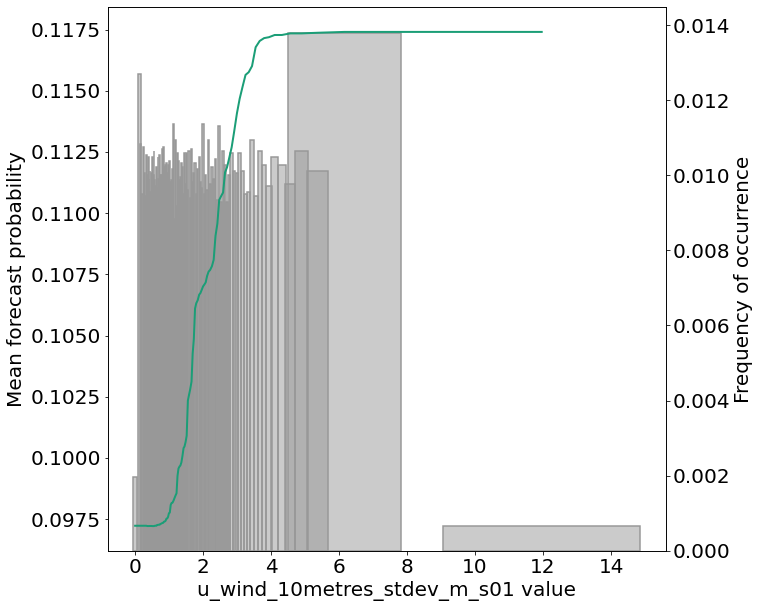

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    model_object=random_forest_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='u_wind_10metres_stdev_m_s01', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='u_wind_10metres_stdev_m_s01',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)